# Scaling Inference

<img src="../../_static/assets/Generic/ray_logo.png" width="20%" loading="lazy">

## About this notebook

### Is it right for you?

This is an introductory notebook that gives a broad overview of the Ray project. It is right for you if:

* you work with model inference problem or you want to scale your existing inference pipelines
* <ToDo\>

### Prerequisites

For this notebook you should have:

* practical Python and machine learning experience
* familiarity with Ray and Ray AIR. Equivalent to completing these training modules:
  * [Overview of Ray](https://github.com/ray-project/ray-educational-materials/blob/main/Introductory_modules/Overview_of_Ray.ipynb)
  * [Introduction to Ray AIR](https://github.com/ray-project/ray-educational-materials/blob/main/Introductory_modules/Introduction_to_Ray_AIR.ipynb)
  * [Ray Core](https://github.com/ray-project/ray-educational-materials/tree/main/Ray_Core)
* familiarity with batch inference problem in ML

### Learning objectives

Upon completion of this notebook, you will know about:

* Inference patterns
* Architectures how to scale inference with Ray

### What will you do?

<ToDo/>

## Part 1: Patterns and architectures for scalable inference

<ToDo, part 1>

ML model lifecycle - diagram with focus

### Patterns for resilient serving

Book chapters
* Stateless Serving Function - implement with Ray Tasks
* Batch Serving - implement with Actors

### Ray architectures for scalable inference

* Stateless inference - Ray Task
* Stateful inference - Ray Actors
* Ray ActorPool - Increment of the previous approach - utility lib.
* Ray AIR Datasets
* Ray AIR BatchPredictor

## Part 2: Notes on data and model

### Data

### Model

## Part 3: Vanilla implementation

*(This implementation is inspired by the [Semantic segmentation](https://huggingface.co/docs/transformers/tasks/semantic_segmentation) guide. Date accessed: Nov 4th, 2022.)*

We start be downloading the SceneParse150 dataset using Hugging Face's `datasets` library. Specifically, we're going to leverage the `load_dataset` utility to reference this dataset as a string (`"scene_parse_150"`). Note that this can take a couple of minutes. We also specify a `split` argument so that we can access `train` and `test` data on the resulting dataset `ds`:

In [1]:
# Load dataset from Hugging Face
from datasets import load_dataset

ds = load_dataset("scene_parse_150", split="train[:50]")

No config specified, defaulting to: scene_parse_150/scene_parsing
Found cached dataset scene_parse_150 (/Users/maxpumperla/.cache/huggingface/datasets/scene_parse_150/scene_parsing/1.0.0/d998c54e1b5c5bad12b4d2ec7e1a5f74eee4c153bc1b089a0001677ae9b3fd75)


Each Hugging Face dataset comes with a `train_test_split` method that we're going to use next. We want 80% of the data to be training data, and 20% held back for testing.

In [10]:
# make tr/test splits
split_ds = ds.train_test_split(test_size=0.2)
train_ds = split_ds["train"]
test_ds = split_ds["test"]

To get a feel for what this dataset consists of, let's print the first of it. Since the train-test split we did is randomized, the resulting image will be different every time you load the dataset.

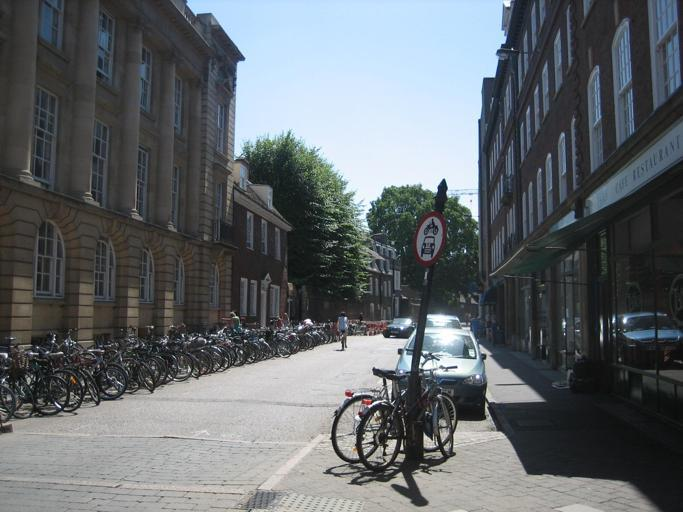

In [3]:
train_ds[0]["image"]

Next, we download the mappings from the Hub (using the `huggingface_hub` library) and create two dictionaries, namely `id2label` and `label2id`. We use these dictionaries to map (bidirectionally) between label IDs (int) and the labels (string) of the respective images. There are a total of 150 labels, or categories in for this dataset, and we print 10 of them at the end. Since we're parsing scenes and want to classify segments of natural images, you can see that the labels describe entities such as walls, floors, roads or grass.

In [4]:
import json
from huggingface_hub import hf_hub_download

repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset"), "r"))

id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)
print(list(id2label.values())[:10])

['wall', 'building', 'sky', 'floor', 'tree', 'ceiling', 'road', 'bed ', 'windowpane', 'grass']


In [5]:
## Preprocessing and augmentations
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("nvidia/mit-b0", reduce_labels=True)

In [6]:
## Augmentations
from torchvision.transforms import ColorJitter

jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)

In [7]:
# train and validate transforms
def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch["image"]]
    labels = [x for x in example_batch["annotation"]]
    inputs = feature_extractor(images, labels)
    return inputs

def val_transforms(example_batch):
    images = [x for x in example_batch["image"]]
    labels = [x for x in example_batch["annotation"]]
    inputs = feature_extractor(images, labels)
    return inputs

In [11]:
# run transform on data
from copy import deepcopy

original_train_ds = deepcopy(train_ds)
original_test_ds = deepcopy(test_ds)

train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

In [12]:
# get pretrained model
from transformers import AutoModelForSemanticSegmentation

pretrained_model_name = "nvidia/mit-b0"
model = AutoModelForSemanticSegmentation.from_pretrained(
    pretrained_model_name, id2label=id2label, label2id=label2id
)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.running_mean', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.classifier.weight', 'decode_head.batch_norm.bias', 'decode_head.linear_fuse.weight', 'decode_head.lin

In [15]:
# instantiate TrainingArguments
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="segformer-b0-scene-parse-150",
    learning_rate=6e-5,
    num_train_epochs=5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    remove_unused_columns=False,
    push_to_hub=False,
)

In [16]:
# eval metric from Evaluate lib.
import evaluate

metric = evaluate.load("mean_iou")

In [17]:
# compute metrics

import torch
import numpy as np

def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        logits_tensor = torch.nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=num_labels,
            ignore_index=255,
            reduce_labels=False,
        )
        for key, value in metrics.items():
            if type(value) is np.ndarray:
                metrics[key] = value.tolist()
        return metrics

In [18]:
# create Trainer
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

In [19]:
# run model training (TODO: optionally load a pre-trained model here instead, e.g. to save time).

# trainer.train()

In [35]:
# trainer.save_model(".")

def load_trained_model(model_path="."):
    return AutoModelForSemanticSegmentation.from_pretrained(
        model_path, id2label=id2label, label2id=label2id
    )

model = load_trained_model()

loading configuration file ./config.json
Model config SegformerConfig {
  "_name_or_path": ".",
  "architectures": [
    "SegformerForSemanticSegmentation"
  ],
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout_prob": 0.1,
  "decoder_hidden_size": 256,
  "depths": [
    2,
    2,
    2,
    2
  ],
  "downsampling_rates": [
    1,
    4,
    8,
    16
  ],
  "drop_path_rate": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_sizes": [
    32,
    64,
    160,
    256
  ],
  "id2label": {
    "0": "wall",
    "1": "building",
    "2": "sky",
    "3": "floor",
    "4": "tree",
    "5": "ceiling",
    "6": "road",
    "7": "bed ",
    "8": "windowpane",
    "9": "grass",
    "10": "cabinet",
    "11": "sidewalk",
    "12": "person",
    "13": "earth",
    "14": "door",
    "15": "table",
    "16": "mountain",
    "17": "plant",
    "18": "curtain",
    "19": "chair",
    "20": "car",
    "21": "water",
    "22": "painting",
    "23": "sofa",
    "24": "shelf",

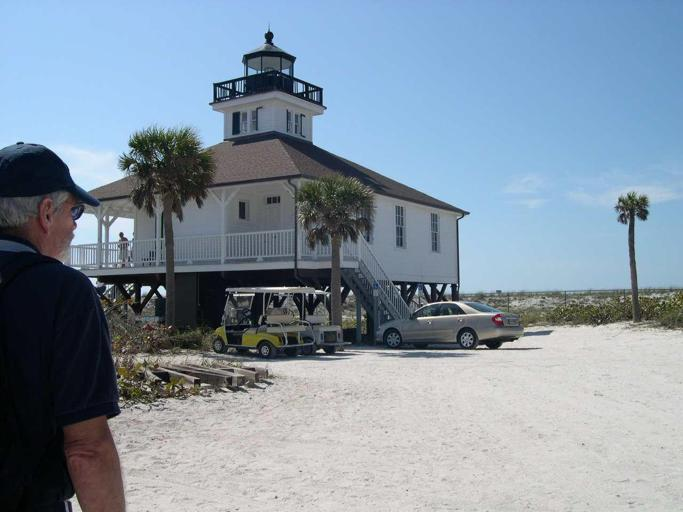

In [78]:
# inference
image = original_test_ds[0]["image"]
image

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # use GPU if available, otherwise use a CPU

def encode_pixels(image):
    encoding = feature_extractor(image, return_tensors="pt")
    pixel_values = encoding.pixel_values.to(device)
    return pixel_values


In [55]:
def compute_logits(model, pixel_values):
    outputs = model(pixel_values=pixel_values)
    return outputs.logits.cpu()


In [56]:
# rescale img
def upsample_logits(logits):
    upsampled_logits = torch.nn.functional.interpolate(
        logits,
        size=image.size[::-1],
        mode="bilinear",
        align_corners=False,
    )

    return upsampled_logits.argmax(dim=1)[0]

def predict(model, image):
    pixel_values = encode_pixels(image)
    logits = compute_logits(model, pixel_values)
    return upsample_logits(logits)

prediction = predict(model, image)
prediction

tensor([[2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        ...,
        [6, 6, 6,  ..., 6, 6, 6],
        [6, 6, 6,  ..., 6, 6, 6],
        [6, 6, 6,  ..., 6, 6, 6]])

In [79]:
# visualize pred
from palette import create_ade20k_label_colormap as ade_palette

# TODO: this only seems to work for the 0th image
def prepare_for_visualisation(image, prediction):
    color_seg = np.zeros((prediction.shape[0], prediction.shape[1], 3), dtype=np.uint8)
    palette = np.array(ade_palette())
    for label, color in enumerate(palette):
        color_seg[prediction == label, :] = color
    color_seg = color_seg[..., ::-1]  # convert to BGR

    img = np.array(image) * 0.5 + color_seg * 0.5  # plot the image with the segmentation map
    img = img.astype(np.uint8)
    return img

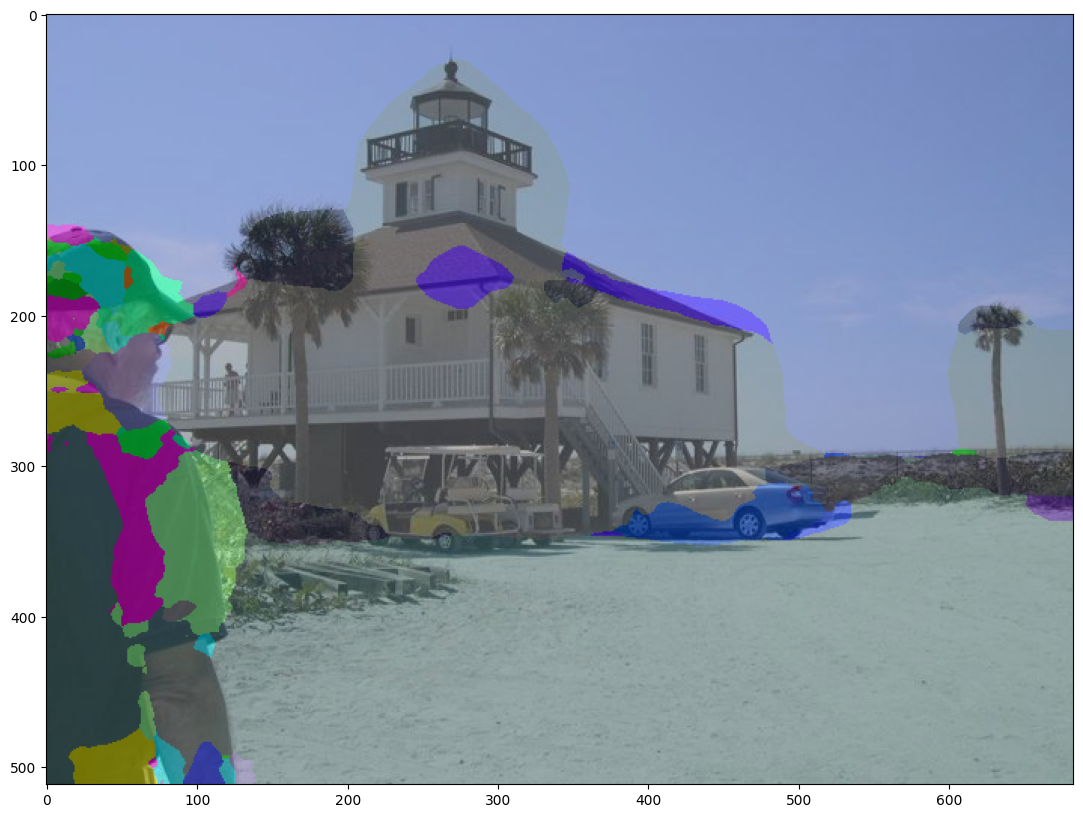

In [80]:
import matplotlib.pyplot as plt

img = prepare_for_visualisation(image, prediction)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

## Part 4: Stateless inference - Ray Tasks

In [42]:
import ray

ray.init()

2022-11-08 16:23:57,016	INFO worker.py:1525 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.7.13
Ray version:,2.1.0
Dashboard:,http://127.0.0.1:8265


In [81]:
@ray.remote
def prediction_task(image):
    model = load_trained_model()
    return predict(model, image)

prediction_refs = [prediction_task.remote(original_test_ds[i]["image"]) for i in range(10)]
predictions = ray.get(prediction_refs)

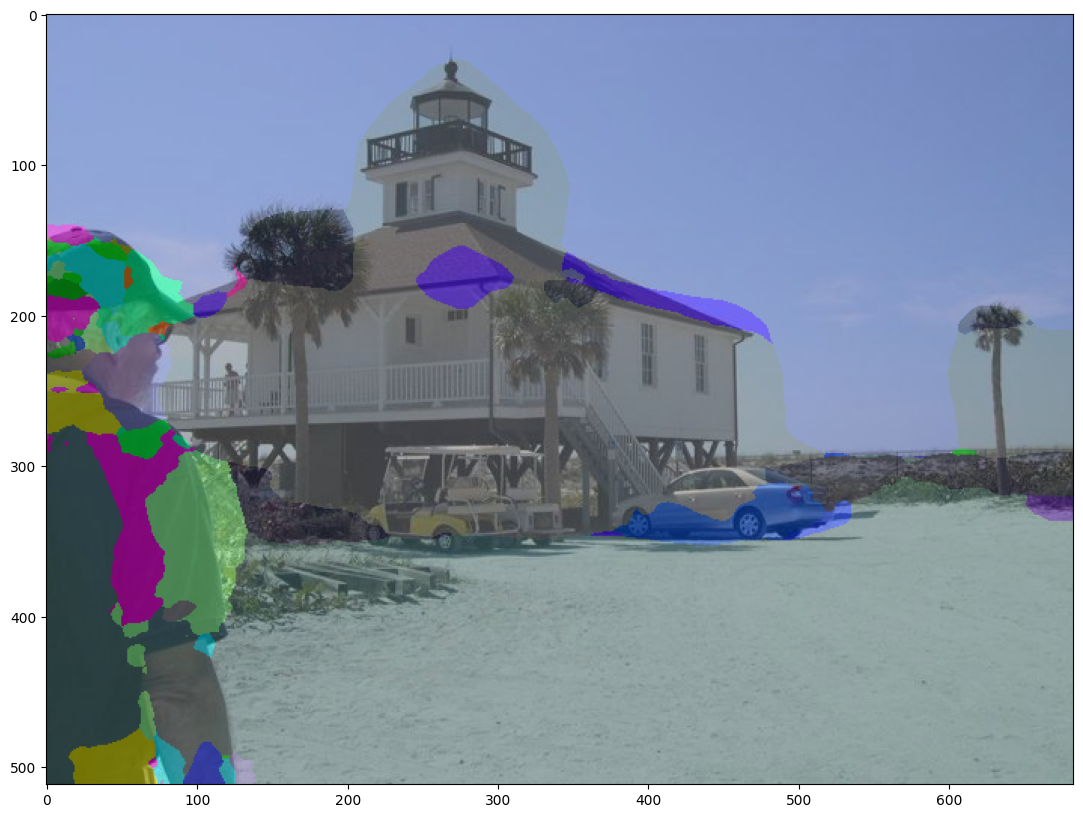

In [82]:
img = prepare_for_visualisation(original_test_ds[0]["image"], predictions[0])

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

## Part 5: Stateful inference - Ray Actors

## Part 6: Stateful inference - Ray ActorPool - Increment of the previous approach - utility lib.

## Part 7: Ray AIR Datasets

## Part 8: Ray AIR BatchPredictor